# Data
We are going to use the GoldMan Sachs data, from yahoo finance.
https://finance.yahoo.com/quote/GS/history?p=GS
In this note book we will be building models to predict the closing share of 10th day based on the previous 9 days.

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Read the Dataset

In [2]:
import pandas as pd

GS = pd.read_csv('GS (9).csv')

GS.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-22,381.399994,385.829987,381.399994,383.869995,378.657684,2019400
1,2022-11-23,383.899994,388.200012,383.410004,386.250000,381.005371,1865400
2,2022-11-25,385.760010,389.440002,385.179993,388.859985,383.579926,1129300
3,2022-11-28,385.429993,388.390015,380.890015,382.359985,377.168152,2232200
4,2022-11-29,381.130005,384.929993,379.260010,383.709991,378.499847,1746900


In [3]:
#Drop the columns we don't need

GS= GS.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

In [4]:
GS

,Date,Close
0,2022-11-22,383.869995
1,2022-11-23,386.250000
2,2022-11-25,388.859985
3,2022-11-28,382.359985
4,2022-11-29,383.709991
...,...,...
96,2023-04-13,332.130005
97,2023-04-14,336.920013
98,2023-04-17,339.679993
99,2023-04-18,333.910004


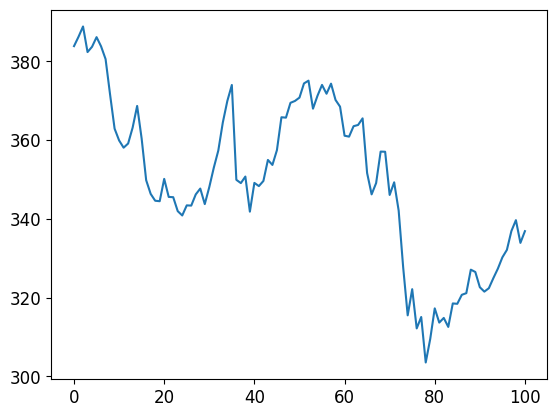

In [5]:
#Plot temp

plt.plot(GS['Close'])
plt.show()

# Data Cleanup

## RESHAPE the data set!

In [6]:
GS.shape

(101, 2)

In [7]:
# Note that not all days have 24 readings. Some are missing.

GS.shape[0]/10

10.1

In [10]:
row_count = GS.shape[0] # store the number of obersvations (daily temperature readings)
row_count
GS = GS[row_count % 10: ]
GS.shape

(100, 2)

In [12]:
GS.groupby(['Date']).count()

,Close
Date,
2022-11-23,1
2022-11-25,1
2022-11-28,1
2022-11-29,1
2022-11-30,1
...,...
2023-04-13,1
2023-04-14,1
2023-04-17,1


In [20]:
# Re-organize the data set by day and hours
temp = np.array(GS['Close']).reshape(100,1)

temp

array([[386.25    ],
       [388.859985],
       [382.359985],
       [383.709991],
       [386.149994],
       [383.809998],
       [380.579987],
       [371.540009],
       [362.910004],
       [359.920013],
       [358.079987],
       [359.140015],
       [363.179993],
       [368.690002],
       [360.380005],
       [349.829987],
       [346.350006],
       [344.609985],
       [344.48999 ],
       [350.160004],
       [345.579987],
       [345.51001 ],
       [341.970001],
       [340.869995],
       [343.429993],
       [343.380005],
       [346.220001],
       [347.700012],
       [343.76001 ],
       [348.079987],
       [353.      ],
       [357.359985],
       [364.480011],
       [369.940002],
       [374.      ],
       [349.920013],
       [349.089996],
       [350.75    ],
       [341.839996],
       [349.140015],
       [348.329987],
       [349.630005],
       [354.970001],
       [353.700012],
       [357.459991],
       [365.809998],
       [365.709991],
       [369.4

In [23]:

# Assume temp is a numpy array with shape (100, 1)
temp_reshaped = np.reshape(temp, (-1, 10))
# Reshape the temp array into (-1, 10) shape, where -1 means to infer the number of rows based on the number of columns (10 in this case)

temp_df = pd.DataFrame(temp_reshaped, columns=np.arange(0,10,1))
temp_df

,0,1,2,3,4,5,6,7,8,9
0,386.250000,388.859985,382.359985,383.709991,386.149994,383.809998,380.579987,371.540009,362.910004,359.920013
1,358.079987,359.140015,363.179993,368.690002,360.380005,349.829987,346.350006,344.609985,344.489990,350.160004
2,345.579987,345.510010,341.970001,340.869995,343.429993,343.380005,346.220001,347.700012,343.760010,348.079987
3,353.000000,357.359985,364.480011,369.940002,374.000000,349.920013,349.089996,350.750000,341.839996,349.140015
4,348.329987,349.630005,354.970001,353.700012,357.459991,365.809998,365.709991,369.470001,369.950012,370.799988
5,374.399994,375.100006,367.989990,371.279999,374.019989,371.779999,374.339996,370.200012,368.500000,361.119995
6,360.890015,363.540009,363.850006,365.529999,351.649994,346.230011,349.100006,357.089996,357.049988,346.079987
7,349.290009,342.089996,327.670013,315.510010,322.149994,312.190002,315.089996,303.540009,309.529999,317.279999
8,313.670013,314.850006,312.570007,318.529999,318.440002,320.720001,321.140015,327.109985,326.519989,322.649994
9,321.529999,322.399994,324.959991,327.369995,330.239990,332.130005,336.920013,339.679993,333.910004,336.890015


# Reshape for Standardizing Data

In [24]:
# Let's create a single sequence (i.e., feature) for standardization

temp_1feature = np.array(temp_df).ravel().reshape(-1,1)

temp_1feature.shape

(100, 1)

In [25]:
temp_1feature

array([[386.25    ],
       [388.859985],
       [382.359985],
       [383.709991],
       [386.149994],
       [383.809998],
       [380.579987],
       [371.540009],
       [362.910004],
       [359.920013],
       [358.079987],
       [359.140015],
       [363.179993],
       [368.690002],
       [360.380005],
       [349.829987],
       [346.350006],
       [344.609985],
       [344.48999 ],
       [350.160004],
       [345.579987],
       [345.51001 ],
       [341.970001],
       [340.869995],
       [343.429993],
       [343.380005],
       [346.220001],
       [347.700012],
       [343.76001 ],
       [348.079987],
       [353.      ],
       [357.359985],
       [364.480011],
       [369.940002],
       [374.      ],
       [349.920013],
       [349.089996],
       [350.75    ],
       [341.839996],
       [349.140015],
       [348.329987],
       [349.630005],
       [354.970001],
       [353.700012],
       [357.459991],
       [365.809998],
       [365.709991],
       [369.4

## Standardize the values

In [26]:
# Next, standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

temp_std = scaler.fit_transform(temp_1feature)

In [29]:
#Pandas version of the reshaped data
temp_reshaped = temp_std.reshape(-1,10)

temp_reshaped.shape

(10, 10)

In [30]:
#Pandas version of the reshaped data

pd.DataFrame(temp_reshaped, columns=np.arange(0,10,1))

,0,1,2,3,4,5,6,7,8,9
0,1.794966,1.921726,1.606039,1.671605,1.790109,1.676462,1.519589,1.080543,0.661408,0.516192
1,0.426827,0.478310,0.674520,0.942126,0.538533,0.026148,-0.142865,-0.227373,-0.233201,0.042176
2,-0.180263,-0.183661,-0.355590,-0.409014,-0.284682,-0.287110,-0.149179,-0.077299,-0.268654,-0.058845
3,0.180107,0.391859,0.737659,1.002835,1.200018,0.030520,-0.009791,0.070830,-0.361904,-0.007362
4,-0.046703,0.016435,0.275784,0.214104,0.396716,0.802252,0.797395,0.980008,1.003321,1.044602
5,1.219444,1.253442,0.908128,1.067915,1.200989,1.092199,1.216531,1.015463,0.932898,0.574472
6,0.563303,0.692005,0.707061,0.788654,0.114541,-0.148693,-0.009305,0.378746,0.376803,-0.155979
7,-0.000077,-0.349762,-1.050100,-1.640677,-1.318192,-1.801921,-1.661076,-2.222027,-1.931110,-1.554714
8,-1.730041,-1.672732,-1.783465,-1.494005,-1.498376,-1.387643,-1.367244,-1.077299,-1.105953,-1.293908
9,-1.348303,-1.306050,-1.181718,-1.064671,-0.925283,-0.833491,-0.600853,-0.466809,-0.747041,-0.602310


# Split the Data

**In certain cases, we cannot use a random split. For example, if we are trying to predict the stock market, we cannot use a random split. We need to use a chronological split.**

BUT, keep in mind if we have something like hourly readings of dayly temperature, we can use a random split on days, but the sequence of the temperature within the day is important to remain sequential.

In this case, we are using a random spli because each day as an independent sample.

In [31]:
from sklearn.model_selection import train_test_split

#train, test = train_test_split(temp_reshaped, test_size=0.3)

# if we neede to maintain the ordering of the data, we can use the following code to split the data
split_point = int(len(temp_reshaped)*0.7)
train, test = temp_reshaped[:split_point], temp_reshaped[split_point:]

In [32]:
train.shape

(7, 10)

In [33]:
train[:2]

array([[ 1.79496607,  1.92172574,  1.60603893,  1.67160494,  1.79010906,
         1.676462  ,  1.51958941,  1.08054297,  0.66140778,  0.51619229],
       [ 0.42682737,  0.47830997,  0.67452039,  0.94212611,  0.53853281,
         0.02614796, -0.14286498, -0.22737293, -0.23320075,  0.04217597]])

In [34]:
test.shape

(3, 10)

In [35]:
test[:2]

array([[-7.72573043e-05, -3.49761739e-01, -1.05009996e+00,
        -1.64067727e+00, -1.31819183e+00, -1.80192077e+00,
        -1.66107618e+00, -2.22202672e+00, -1.93110967e+00,
        -1.55471386e+00],
       [-1.73004078e+00, -1.67273182e+00, -1.78346499e+00,
        -1.49400486e+00, -1.49837576e+00, -1.38764259e+00,
        -1.36724369e+00, -1.07729895e+00, -1.10595340e+00,
        -1.29390823e+00]])

# Create Input and Target values

The first 9 days will be input to predict the 10th day closing share(i.e., target)

In [37]:
# The first 9 columns (from 0 to 8) are inputs

train_inputs = train[:,:9]


pd.DataFrame(train_inputs, columns=np.arange(0,9,1))

,0,1,2,3,4,5,6,7,8
0,1.794966,1.921726,1.606039,1.671605,1.790109,1.676462,1.519589,1.080543,0.661408
1,0.426827,0.478310,0.674520,0.942126,0.538533,0.026148,-0.142865,-0.227373,-0.233201
2,-0.180263,-0.183661,-0.355590,-0.409014,-0.284682,-0.287110,-0.149179,-0.077299,-0.268654
3,0.180107,0.391859,0.737659,1.002835,1.200018,0.030520,-0.009791,0.070830,-0.361904
4,-0.046703,0.016435,0.275784,0.214104,0.396716,0.802252,0.797395,0.980008,1.003321
5,1.219444,1.253442,0.908128,1.067915,1.200989,1.092199,1.216531,1.015463,0.932898
6,0.563303,0.692005,0.707061,0.788654,0.114541,-0.148693,-0.009305,0.378746,0.376803


## Add one more dimension to make it ready for RNNs

See here for more details: https://keras.io/layers/recurrent/, and https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e


In [38]:
train_inputs

array([[ 1.79496607,  1.92172574,  1.60603893,  1.67160494,  1.79010906,
         1.676462  ,  1.51958941,  1.08054297,  0.66140778],
       [ 0.42682737,  0.47830997,  0.67452039,  0.94212611,  0.53853281,
         0.02614796, -0.14286498, -0.22737293, -0.23320075],
       [-0.18026264, -0.18366123, -0.35558956, -0.40901377, -0.28468183,
        -0.28710961, -0.14917895, -0.07729896, -0.26865383],
       [ 0.18010662,  0.39185889,  0.73765863,  1.00283511,  1.20001785,
         0.03052027, -0.00979133,  0.07083042, -0.36190354],
       [-0.04670284,  0.0164354 ,  0.27578406,  0.21410425,  0.3967159 ,
         0.80225238,  0.79739532,  0.98000848,  1.00332127],
       [ 1.21944444,  1.25344207,  0.90812849,  1.06791502,  1.20098866,
         1.09219862,  1.21653051,  1.01546307,  0.93289824],
       [ 0.56330257,  0.69200536,  0.70706105,  0.78865361,  0.11454061,
        -0.1486928 , -0.00930517,  0.37874628,  0.37680321]])

In [39]:
train_inputs.shape 

(7, 9)

In [40]:
#Create an additional dimension for train

train_x = train_inputs[:,:,np.newaxis]

train_x.shape 

(7, 9, 1)

In [41]:
train_x

array([[[ 1.79496607],
        [ 1.92172574],
        [ 1.60603893],
        [ 1.67160494],
        [ 1.79010906],
        [ 1.676462  ],
        [ 1.51958941],
        [ 1.08054297],
        [ 0.66140778]],

       [[ 0.42682737],
        [ 0.47830997],
        [ 0.67452039],
        [ 0.94212611],
        [ 0.53853281],
        [ 0.02614796],
        [-0.14286498],
        [-0.22737293],
        [-0.23320075]],

       [[-0.18026264],
        [-0.18366123],
        [-0.35558956],
        [-0.40901377],
        [-0.28468183],
        [-0.28710961],
        [-0.14917895],
        [-0.07729896],
        [-0.26865383]],

       [[ 0.18010662],
        [ 0.39185889],
        [ 0.73765863],
        [ 1.00283511],
        [ 1.20001785],
        [ 0.03052027],
        [-0.00979133],
        [ 0.07083042],
        [-0.36190354]],

       [[-0.04670284],
        [ 0.0164354 ],
        [ 0.27578406],
        [ 0.21410425],
        [ 0.3967159 ],
        [ 0.80225238],
        [ 0.79739532],
   

## Set the target

In [42]:
# The last column  is TARGET

train_target = train[:,-1]


pd.DataFrame(train_target, columns=['9'])

,9
0,0.516192
1,0.042176
2,-0.058845
3,-0.007362
4,1.044602
5,0.574472
6,-0.155979


## Repeat for TEST

In [43]:
test.shape

(3, 10)

In [44]:
# The first 23 columns (from 0 to 22) are inputs

test_inputs = test[:,:9]

In [45]:
#Create an additional dimension for test

test_x = test_inputs[:,:,np.newaxis]

test_x.shape 

(3, 9, 1)

In [46]:
# The last column (23) is TARGET

test_target = test[:,-1]


pd.DataFrame(test_target, columns=['9'])

,9
0,-1.554714
1,-1.293908
2,-0.602310


# A normal (cross-sectional) NN

This model assumes that the data is NOT a time-series data set. It treats the data as cross-sectional and the columns being independent of each other.

In [47]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[9, 1]),
    keras.layers.Dense(9, activation='relu'),
    keras.layers.Dense(1, activation=None)
    
])

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 590ms/step - loss: 0.3277
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.3225
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.3174
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.3123
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.3073
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.3023
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.2974
Epoch 8/100
1/1 [==============================] - 0s 8ms/step - loss: 0.2926
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.2878
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.2831
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 0.2784
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.2738
Epoch 13/100
1/1 [==============================] - 0s 6ms/

### Predictions

In [48]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 97ms/step


In [49]:
# Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [50]:
comparison

,actual,predicted
0,317.279999,345.457062
1,322.649994,335.934052
2,336.890015,339.797577


In [51]:
mean_squared_error(comparison['actual'], comparison['predicted'])

326.2889888206333

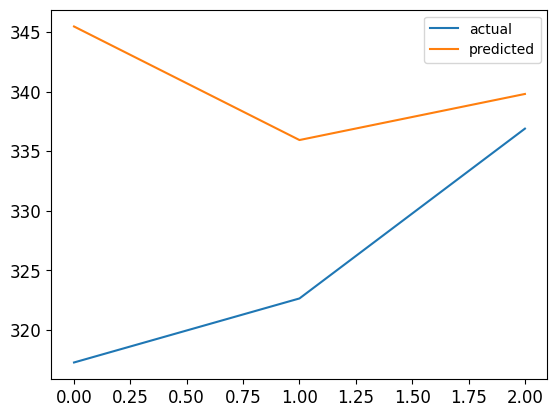

In [52]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Simple RNN

Simplest recurrent neural network

In [55]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 1s 925ms/step - loss: 0.3013
Epoch 2/30
1/1 [==============================] - 0s 5ms/step - loss: 0.2863
Epoch 3/30
1/1 [==============================] - 0s 5ms/step - loss: 0.2714
Epoch 4/30
1/1 [==============================] - 0s 5ms/step - loss: 0.2565
Epoch 5/30
1/1 [==============================] - 0s 6ms/step - loss: 0.2426
Epoch 6/30
1/1 [==============================] - 0s 5ms/step - loss: 0.2296
Epoch 7/30
1/1 [==============================] - 0s 9ms/step - loss: 0.2171
Epoch 8/30
1/1 [==============================] - 0s 6ms/step - loss: 0.2050
Epoch 9/30
1/1 [==============================] - 0s 6ms/step - loss: 0.1936
Epoch 10/30
1/1 [==============================] - 0s 6ms/step - loss: 0.1826
Epoch 11/30
1/1 [==============================] - 0s 8ms/step - loss: 0.1717
Epoch 12/30
1/1 [==============================] - 0s 6ms/step - loss: 0.1612
Epoch 13/30
1/1 [==============================] - 0s 6ms/step - loss: 

### Predictions

In [57]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 158ms/step


In [58]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [59]:
comparison

,actual,predicted
0,317.279999,336.124115
1,322.649994,340.122681
2,336.890015,344.311829


In [60]:
mean_squared_error(comparison['actual'], comparison['predicted'])

238.49293467473413

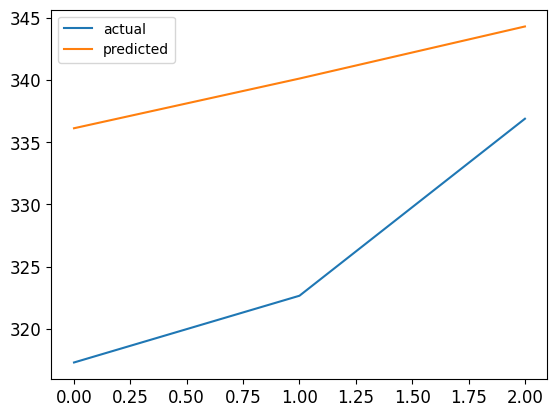

In [61]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

## Simple RNN with more layers

**Be careful: when stacking RNN layers, you have to set "return_sequences" to True. This enables the layer to send a "sequence" of values to the next layer -- jut like how it uses a sequence of values for training. However, if the output of RNN is sent to a DENSE layer, then a single value should be sent. That's why there is no "return sequences" right before DENSE layers.**

In [62]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.2442
Epoch 2/30
1/1 [==============================] - 0s 10ms/step - loss: 0.1642
Epoch 3/30
1/1 [==============================] - 0s 11ms/step - loss: 0.1099
Epoch 4/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0784
Epoch 5/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0630
Epoch 6/30
1/1 [==============================] - 0s 10ms/step - loss: 0.0589
Epoch 7/30
1/1 [==============================] - 0s 13ms/step - loss: 0.0617
Epoch 8/30
1/1 [==============================] - 0s 8ms/step - loss: 0.0661
Epoch 9/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0652
Epoch 10/30
1/1 [==============================] - 0s 8ms/step - loss: 0.0588
Epoch 11/30
1/1 [==============================] - 0s 8ms/step - loss: 0.0493
Epoch 12/30
1/1 [==============================] - 0s 7ms/step - loss: 0.0396
Epoch 13/30
1/1 [==============================] - 0s 9ms/step - loss:

### Predictions

In [64]:
#Predict:
y_pred = model.predict(test_x)


1/1 [==============================] - 0s 249ms/step


In [65]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [67]:
comparison

,actual,predicted
0,317.279999,361.775787
1,322.649994,352.527496
2,336.890015,349.489929


In [68]:
mean_squared_error(comparison['actual'], comparison['predicted'])

1010.4327216597309

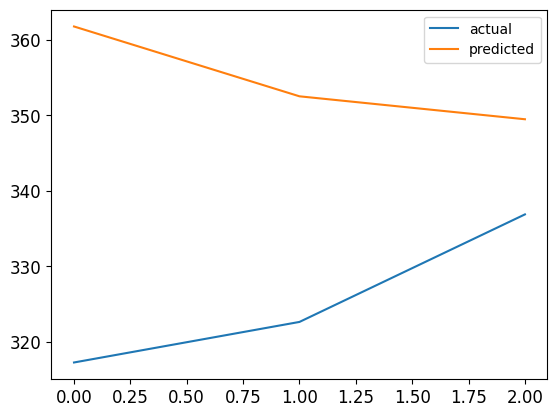

In [69]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

## Results
the mean squared error is 1010 and this is the worst performing model as the actual & predicted values do not make any sense

# LSTM with one layer

In [70]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [71]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=50)

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.2150
Epoch 2/50
1/1 [==============================] - 0s 5ms/step - loss: 0.2106
Epoch 3/50
1/1 [==============================] - 0s 6ms/step - loss: 0.2063
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 0.2021
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1979
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1938
Epoch 7/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1897
Epoch 8/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1856
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1815
Epoch 10/50
1/1 [==============================] - 0s 10ms/step - loss: 0.1775
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1735
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1695
Epoch 13/50
1/1 [==============================] - 0s 7ms/step - loss: 0.

### Predictions

In [72]:
#Predict:
y_pred = model.predict(test_x)


1/1 [==============================] - 0s 189ms/step


In [73]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [74]:
mean_squared_error(comparison['actual'], comparison['predicted'])

75.16698447133393

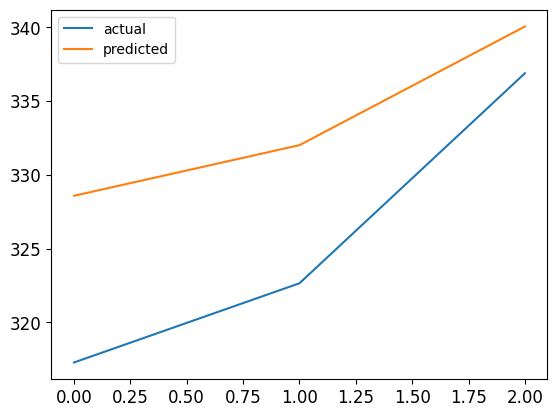

In [75]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Results
 The mean squared error is 75.16 which is very high, and the actual and predicted values do not even converge nor are close enough, this LTSM model doesnt seem to achieve the best results

# Conv1D

### Last Layer: GRU (you can change it to SimpleRNN or LSTM as well)

In [76]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [77]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 0.2777
Epoch 2/30
1/1 [==============================] - 0s 8ms/step - loss: 0.2545
Epoch 3/30
1/1 [==============================] - 0s 9ms/step - loss: 0.2326
Epoch 4/30
1/1 [==============================] - 0s 8ms/step - loss: 0.2130
Epoch 5/30
1/1 [==============================] - 0s 9ms/step - loss: 0.1962
Epoch 6/30
1/1 [==============================] - 0s 9ms/step - loss: 0.1809
Epoch 7/30
1/1 [==============================] - 0s 10ms/step - loss: 0.1671
Epoch 8/30
1/1 [==============================] - 0s 9ms/step - loss: 0.1552
Epoch 9/30
1/1 [==============================] - 0s 10ms/step - loss: 0.1447
Epoch 10/30
1/1 [==============================] - 0s 10ms/step - loss: 0.1354
Epoch 11/30
1/1 [==============================] - 0s 14ms/step - loss: 0.1275
Epoch 12/30
1/1 [==============================] - 0s 10ms/step - loss: 0.1208
Epoch 13/30
1/1 [==============================] - 0s 10ms/step - los

### Predictions

In [78]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 1s 624ms/step


In [79]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [80]:
mean_squared_error(comparison['actual'], comparison['predicted'])

514.663031855598

# Sliding window

Prior 9 days predicts next day closing price

In [97]:
steps_for_prediction = 9
steps_to_predict = 1



In [98]:
train

array([[ 1.79496607,  1.92172574,  1.60603893,  1.67160494,  1.79010906,
         1.676462  ,  1.51958941,  1.08054297,  0.66140778,  0.51619229],
       [ 0.42682737,  0.47830997,  0.67452039,  0.94212611,  0.53853281,
         0.02614796, -0.14286498, -0.22737293, -0.23320075,  0.04217597],
       [-0.18026264, -0.18366123, -0.35558956, -0.40901377, -0.28468183,
        -0.28710961, -0.14917895, -0.07729896, -0.26865383, -0.05884464],
       [ 0.18010662,  0.39185889,  0.73765863,  1.00283511,  1.20001785,
         0.03052027, -0.00979133,  0.07083042, -0.36190354, -0.00736205],
       [-0.04670284,  0.0164354 ,  0.27578406,  0.21410425,  0.3967159 ,
         0.80225238,  0.79739532,  0.98000848,  1.00332127,  1.04460223],
       [ 1.21944444,  1.25344207,  0.90812849,  1.06791502,  1.20098866,
         1.09219862,  1.21653051,  1.01546307,  0.93289824,  0.57447206],
       [ 0.56330257,  0.69200536,  0.70706105,  0.78865361,  0.11454061,
        -0.1486928 , -0.00930517,  0.37874628

In [99]:
train.flatten().shape

(70,)

In [100]:
train_inputs_sw = []
train_target_sw = []

for i in range(0,70-10):
    input_row = train.flatten()[i:i+steps_for_prediction]
    target_row = train.flatten()[i+steps_for_prediction:i+steps_for_prediction+steps_to_predict]
    train_inputs_sw.append((input_row))
    train_target_sw.append((target_row))

In [101]:
train_inputs = np.vstack(train_inputs_sw)

train_targets = np.vstack(train_target_sw)

In [103]:
train_targets

array([[ 0.51619229],
       [ 0.42682737],
       [ 0.47830997],
       [ 0.67452039],
       [ 0.94212611],
       [ 0.53853281],
       [ 0.02614796],
       [-0.14286498],
       [-0.22737293],
       [-0.23320075],
       [ 0.04217597],
       [-0.18026264],
       [-0.18366123],
       [-0.35558956],
       [-0.40901377],
       [-0.28468183],
       [-0.28710961],
       [-0.14917895],
       [-0.07729896],
       [-0.26865383],
       [-0.05884464],
       [ 0.18010662],
       [ 0.39185889],
       [ 0.73765863],
       [ 1.00283511],
       [ 1.20001785],
       [ 0.03052027],
       [-0.00979133],
       [ 0.07083042],
       [-0.36190354],
       [-0.00736205],
       [-0.04670284],
       [ 0.0164354 ],
       [ 0.27578406],
       [ 0.21410425],
       [ 0.3967159 ],
       [ 0.80225238],
       [ 0.79739532],
       [ 0.98000848],
       [ 1.00332127],
       [ 1.04460223],
       [ 1.21944444],
       [ 1.25344207],
       [ 0.90812849],
       [ 1.06791502],
       [ 1

In [104]:
# Repeat for test

test_inputs_sw = []
test_target_sw = []

for i in range(0,test.flatten().shape[0]-10):
    input_row = test.flatten()[i:i+steps_for_prediction]
    target_row = test.flatten()[i+steps_for_prediction:i+steps_for_prediction+steps_to_predict]
    test_inputs_sw.append((input_row))
    test_target_sw.append((target_row))
    
test_inputs = np.vstack(test_inputs_sw)

test_targets = np.vstack(test_target_sw)

# GRU

In [105]:
model = keras.models.Sequential([
    keras.layers.GRU(64, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(steps_to_predict, activation=None)
])

In [106]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_inputs, train_targets, epochs=50)

Epoch 1/50
2/2 [==============================] - 3s 14ms/step - loss: 0.4012
Epoch 2/50
2/2 [==============================] - 0s 11ms/step - loss: 0.3559
Epoch 3/50
2/2 [==============================] - 0s 11ms/step - loss: 0.3156
Epoch 4/50
2/2 [==============================] - 0s 16ms/step - loss: 0.2774
Epoch 5/50
2/2 [==============================] - 0s 13ms/step - loss: 0.2494
Epoch 6/50
2/2 [==============================] - 0s 12ms/step - loss: 0.2213
Epoch 7/50
2/2 [==============================] - 0s 16ms/step - loss: 0.2025
Epoch 8/50
2/2 [==============================] - 0s 13ms/step - loss: 0.1791
Epoch 9/50
2/2 [==============================] - 0s 12ms/step - loss: 0.1634
Epoch 10/50
2/2 [==============================] - 0s 12ms/step - loss: 0.1521
Epoch 11/50
2/2 [==============================] - 0s 12ms/step - loss: 0.1459
Epoch 12/50
2/2 [==============================] - 0s 11ms/step - loss: 0.1436
Epoch 13/50
2/2 [==============================] - 0s 13ms/st

### Predictions

In [107]:
#Predict:
y_pred = model.predict(test_inputs)

1/1 [==============================] - 0s 320ms/step


In [108]:
#Remember, these are standardized values. 

actual = pd.DataFrame(scaler.inverse_transform(test_targets))
predicted = pd.DataFrame(scaler.inverse_transform(y_pred))

In [109]:
actual

,0
0,317.279999
1,313.670013
2,314.850006
3,312.570007
4,318.529999
5,318.440002
6,320.720001
7,321.140015
8,327.109985
9,326.519989


In [110]:
predicted

,0
0,321.620972
1,327.569489
2,321.524719
3,324.942810
4,321.587646
5,330.258118
6,326.354462
7,329.944366
8,328.865540
9,336.359406


In [111]:
mean_squared_error(actual, predicted)

57.320720066862876

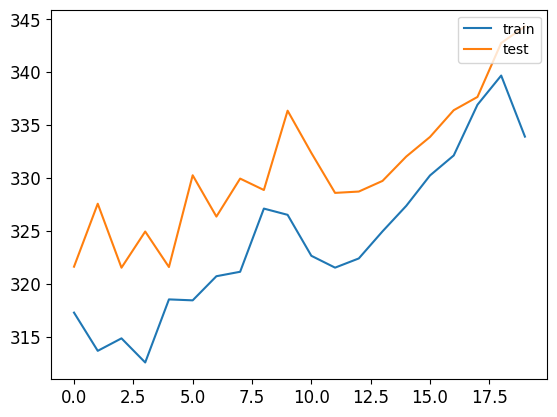

In [116]:

plt.plot(actual)
plt.plot(predicted)

plt.legend(['train', 'test'], loc='upper right')


plt.show()

#Results
The above graph is decent but not close to the actual values, the predicted values are slightly off the charts, as the mean squared error is 57.32 which is high.

## Summary

RNN (Recurrent Neural Networks), LSTM (Long Short-Term Memory), GRU (Gated Recurrent Unit), and Conv1D (1-dimensional convolutional neural network) are all deep learning techniques commonly used for sequence data processing, including time series data analysis.

RNN is a neural network that can process sequences of input data of arbitrary length. RNNs are designed to work with sequential data by taking the output from the previous time step as input to the current time step. This makes them particularly useful for time series data analysis.

LSTM is a type of RNN architecture that has been specifically designed to deal with the vanishing gradient problem. The vanishing gradient problem occurs when the gradients in the backpropagation algorithm for training the neural network become so small that the weights of the network stop updating. LSTM addresses this problem by introducing a memory cell that can store information over long periods of time and by using gates that control the flow of information through the network.

GRU is a simplified version of LSTM that also uses gates to control the flow of information but has fewer parameters than LSTM. GRU is faster to train and requires less memory than LSTM but may not perform as well on more complex problems.

Conv1D is a type of neural network architecture that uses 1-dimensional convolutional layers to extract features from the input sequence data. Conv1D can be used for time series analysis by treating the time series data as a 1-dimensional sequence. Conv1D can learn local patterns and long-range dependencies in the input sequence data and has been shown to be effective for tasks such as anomaly detection and classification.

In summary, RNN, LSTM, GRU, and Conv1D are all powerful deep learning techniques for time series analysis.

**Based on the above results, GRU is a type of RNN that has a gating mechanism to selectively update information and avoid vanishing gradients. It can be especially useful in cases where long-term dependencies are important, as it can learn to retain information over a longer period of time compared to a standard RNN. It's possible that in the case of the Yahoo Finance dataset for Goldman Sachs, the GRU was better able to capture the underlying patterns and relationships in the data compared to the other models we tried.**







lets use another method to build models and compare the predicting results & see if it differs

# Method 2 (using tampa temps notebook as reference)

In [2]:
import pandas as pd


GS = pd.read_csv('GS (9).csv')

GS

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-22,381.399994,385.829987,381.399994,383.869995,378.657684,2019400
1,2022-11-23,383.899994,388.200012,383.410004,386.250000,381.005371,1865400
2,2022-11-25,385.760010,389.440002,385.179993,388.859985,383.579926,1129300
3,2022-11-28,385.429993,388.390015,380.890015,382.359985,377.168152,2232200
4,2022-11-29,381.130005,384.929993,379.260010,383.709991,378.499847,1746900
...,...,...,...,...,...,...,...
96,2023-04-13,330.079987,332.940002,327.000000,332.130005,332.130005,1765500
97,2023-04-14,336.529999,339.630005,334.320007,336.920013,336.920013,2274400
98,2023-04-17,336.000000,340.450012,333.679993,339.679993,339.679993,3012100
99,2023-04-18,328.000000,336.549988,326.130005,333.910004,333.910004,7549500


In [3]:
GS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       101 non-null    object 
 1   Open       101 non-null    float64
 2   High       101 non-null    float64
 3   Low        101 non-null    float64
 4   Close      101 non-null    float64
 5   Adj Close  101 non-null    float64
 6   Volume     101 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ KB


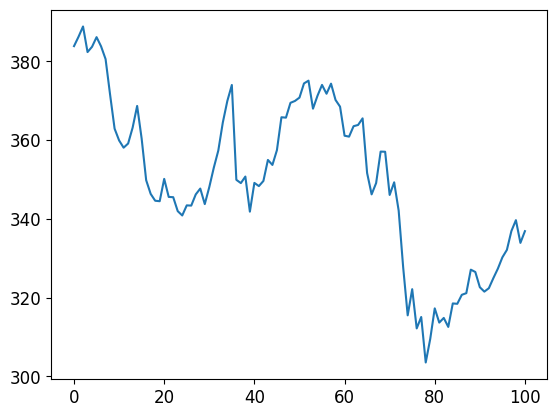

In [4]:
#Plot temp

plt.plot(GS['Close'])
plt.show()

In [5]:
GS = GS[['Close']] 

In [6]:
GS.shape

(101, 1)

In [7]:
row_count = GS.shape[0] # store the number of obersvations (daily temperature readings)
row_count

101

In [8]:
stocks = GS.to_numpy() # to make things easier, we create a numpy array from our dataframe of temperatures
stocks.shape

(101, 1)

In [9]:
sequence_length = 10  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [10]:
stocks = stocks[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
stocks.shape

(100, 1)

In [11]:
stocks.shape

(100, 1)

In [12]:
stocks = stocks.reshape(row_count //sequence_length,sequence_length) # note that temps are a multiple of sequence length, we can split the data into rows of sequence length.
stocks

array([[386.25    , 388.859985, 382.359985, 383.709991, 386.149994,
        383.809998, 380.579987, 371.540009, 362.910004, 359.920013],
       [358.079987, 359.140015, 363.179993, 368.690002, 360.380005,
        349.829987, 346.350006, 344.609985, 344.48999 , 350.160004],
       [345.579987, 345.51001 , 341.970001, 340.869995, 343.429993,
        343.380005, 346.220001, 347.700012, 343.76001 , 348.079987],
       [353.      , 357.359985, 364.480011, 369.940002, 374.      ,
        349.920013, 349.089996, 350.75    , 341.839996, 349.140015],
       [348.329987, 349.630005, 354.970001, 353.700012, 357.459991,
        365.809998, 365.709991, 369.470001, 369.950012, 370.799988],
       [374.399994, 375.100006, 367.98999 , 371.279999, 374.019989,
        371.779999, 374.339996, 370.200012, 368.5     , 361.119995],
       [360.890015, 363.540009, 363.850006, 365.529999, 351.649994,
        346.230011, 349.100006, 357.089996, 357.049988, 346.079987],
       [349.290009, 342.089996, 327.67001

In [13]:
# we can now see that our days have been organized into rows of sequence length. 

In [14]:
# create our X and y. 
# X will be the 9 days prior...
X = stocks[:, :-1] # all rows, all columns except the last one
# y will be the 10th day (what we are trying to predict)
y = stocks[:, -1] # all rows, only the last column

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(7, 9, 1)
(3, 9, 1)


In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(64, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [18]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
1/1 [==============================] - 3s 3s/step - loss: 120533.2500 - root_mean_squared_error: 347.1790 - val_loss: 118971.9609 - val_root_mean_squared_error: 344.9231
Epoch 2/600
1/1 [==============================] - 0s 46ms/step - loss: 120505.7891 - root_mean_squared_error: 347.1394 - val_loss: 118944.5312 - val_root_mean_squared_error: 344.8834
Epoch 3/600
1/1 [==============================] - 0s 43ms/step - loss: 120478.1875 - root_mean_squared_error: 347.0997 - val_loss: 118915.7891 - val_root_mean_squared_error: 344.8417
Epoch 4/600
1/1 [==============================] - 0s 47ms/step - loss: 120449.2500 - root_mean_squared_error: 347.0580 - val_loss: 118885.6250 - val_root_mean_squared_error: 344.7979
Epoch 5/600
1/1 [==============================] - 0s 44ms/step - loss: 120418.8750 - root_mean_squared_error: 347.0142 - val_loss: 118853.6875 - val_root_mean_squared_error: 344.7516
Epoch 6/600
1/1 [==============================] - 0s 42ms/step - loss: 120386.710

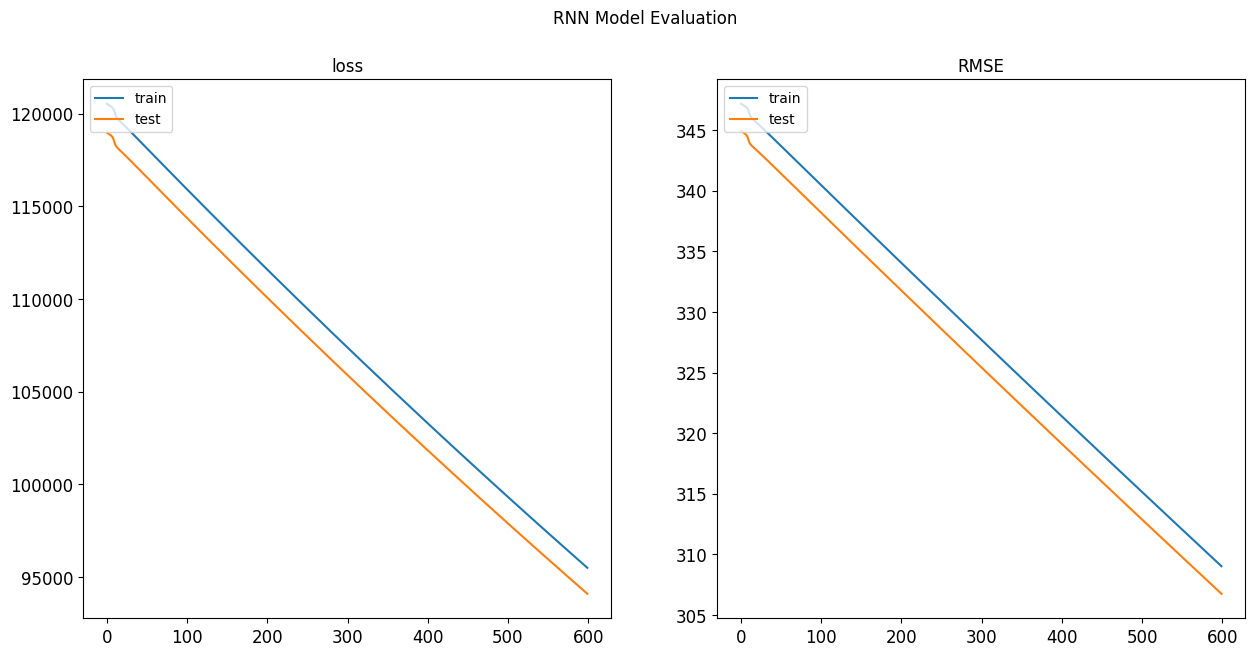

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [21]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 0s 233ms/step


306.74068160990396

Now, let's say our past 9 days of stocks were as follow....

In [22]:
prior_days = np.array(
    [ 383.869995,386.25,388.859985,382.359985,383.709991,386.149994,383.809998,380.579987,371.540009 ]
)

# reshape into the three dimensions for input into model
prior_days = prior_days.reshape(1, 9, 1) # 1 row, 9 time steps (features), and 1 output/prediction)

In [23]:
model.predict(prior_days) # note the structure of the prediction

1/1 [==============================] - 0s 28ms/step


array([[38.329823]], dtype=float32)

In [24]:
tomorrows_temp = model.predict(prior_days)[0][0] # we see the predicted temp is embedded inside two dimensions

1/1 [==============================] - 0s 26ms/step


In [79]:
print(f"Tomorrow's predicted stock price is {tomorrows_temp:.2f}.")

Tomorrow's predicted stock price is 407.60.


### Results
based on the past 9 days the 10th day stock price is 407

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(64, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [27]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(64, activation='relu', return_sequences=True, input_shape=[n_steps, n_inputs]),
    keras.layers.SimpleRNN(64, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 303071.5938
Epoch 2/30
1/1 [==============================] - 0s 8ms/step - loss: 239745.2969
Epoch 3/30
1/1 [==============================] - 0s 10ms/step - loss: 194320.1406
Epoch 4/30
1/1 [==============================] - 0s 10ms/step - loss: 158899.0469
Epoch 5/30
1/1 [==============================] - 0s 9ms/step - loss: 132233.2188
Epoch 6/30
1/1 [==============================] - 0s 9ms/step - loss: 110301.7266
Epoch 7/30
1/1 [==============================] - 0s 9ms/step - loss: 95988.8047
Epoch 8/30
1/1 [==============================] - 0s 9ms/step - loss: 87825.6016
Epoch 9/30
1/1 [==============================] - 0s 9ms/step - loss: 77677.5859
Epoch 10/30
1/1 [==============================] - 0s 9ms/step - loss: 67433.0781
Epoch 11/30
1/1 [==============================] - 0s 10ms/step - loss: 57316.9805
Epoch 12/30
1/1 [==============================] - 0s 11ms/step - loss: 47172.3516
Epoch 13/30
1/1 

### Predictions

In [29]:

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 0s 320ms/step


32.7212689446225

In [30]:
prior_days1 = np.array(
    [ 383.869995,386.25,388.859985,382.359985,383.709991,386.149994,383.809998,380.579987,371.540009 ]
)

# reshape into the three dimensions for input into model
prior_days1 = prior_days1.reshape(1, 9, 1) # 1 row, 9 time steps (features), and 1 output/prediction)

In [31]:
model.predict(prior_days1) # note the structure of the prediction

1/1 [==============================] - 0s 26ms/step


array([[341.5145]], dtype=float32)

In [32]:
tomorrows_temp = model.predict(prior_days1)[0][0] # we see the predicted temp is embedded inside two dimensions

1/1 [==============================] - 0s 26ms/step


In [33]:
print(f"Tomorrow's predicted stock close is {tomorrows_temp:.2f} ")

Tomorrow's predicted stock close is 341.51 


# Results
The mean squared error is decent and pretty low at 32 and the predicted stock of 10th day is 341 and the plotted test & train data are close, this is one of the best performing model

In [34]:

start_time = time.time()

early_stop = EarlyStopping( min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
1/1 [==============================] - 0s 409ms/step - loss: 1214.3917 - val_loss: 1631.0089
Epoch 2/600
1/1 [==============================] - 0s 41ms/step - loss: 1798.8855 - val_loss: 2076.1423
Epoch 3/600
1/1 [==============================] - 0s 41ms/step - loss: 2255.7720 - val_loss: 2297.8010
Epoch 4/600
1/1 [==============================] - 0s 42ms/step - loss: 2484.1780 - val_loss: 2273.7478
Epoch 5/600
1/1 [==============================] - 0s 43ms/step - loss: 2461.1526 - val_loss: 2047.9113
Epoch 6/600
1/1 [==============================] - 0s 45ms/step - loss: 2223.1794 - val_loss: 1661.0898
Epoch 7/600
1/1 [==============================] - 0s 44ms/step - loss: 1823.7291 - val_loss: 1184.1753
Epoch 8/600
1/1 [==============================] - 0s 50ms/step - loss: 1329.1185 - val_loss: 736.5952
Epoch 9/600
1/1 [==============================] - 0s 45ms/step - loss: 853.7835 - val_loss: 372.9408
Epoch 10/600
1/1 [==============================] - 0s 42ms/step -

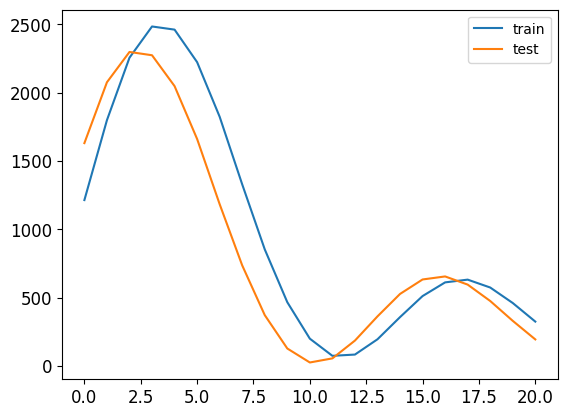

In [35]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train', 'test'], loc='upper right')


plt.show()

# LSTM with one layer

In [36]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[n_steps, n_inputs]),
    keras.layers.Dense(1, activation=None)
])

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mean_squared_error", optimizer='Adam')
early_stop = EarlyStopping( min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(X_train, y_train, epochs=30,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop])

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 202575.1719 - val_loss: 193153.7500
Epoch 2/30
1/1 [==============================] - 0s 33ms/step - loss: 185310.3594 - val_loss: 176579.4375
Epoch 3/30
1/1 [==============================] - 0s 33ms/step - loss: 192271.7969 - val_loss: 117440.0938
Epoch 4/30
1/1 [==============================] - 0s 33ms/step - loss: 177904.7188 - val_loss: 300104.5312
Epoch 5/30
1/1 [==============================] - 0s 33ms/step - loss: 252603.8438 - val_loss: 189691.5781
Epoch 6/30
1/1 [==============================] - 0s 32ms/step - loss: 289521.5625 - val_loss: 228676.1875
Epoch 7/30
1/1 [==============================] - 0s 34ms/step - loss: 260912.6250 - val_loss: 236307.9219
Epoch 8/30
1/1 [==============================] - 0s 36ms/step - loss: 231998.6094 - val_loss: 251183.7500
Epoch 9/30
1/1 [==============================] - 0s 34ms/step - loss: 243523.2656 - val_loss: 225379.1875
Epoch 10/30
1/1 [======================

### Predictions

In [38]:
#Predict:
y_pred = model.predict(X_test)


1/1 [==============================] - 0s 166ms/step


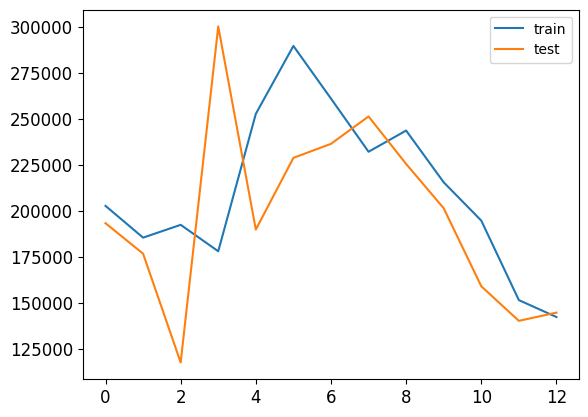

In [39]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train', 'test'], loc='upper right')


plt.show()

In [80]:

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 0s 23ms/step


27.4027801094376

In [81]:
prior_days2 = np.array(
    [ 383.869995,386.25,388.859985,382.359985,383.709991,386.149994,383.809998,380.579987,371.540009 ]
)

# reshape into the three dimensions for input into model
prior_days2 = prior_days2.reshape(1, 9, 1) # 1 row, 59 time steps (features), and 1 output/prediction)

In [82]:
model.predict(prior_days2) # note the structure of the prediction

1/1 [==============================] - 0s 20ms/step


array([[407.59747]], dtype=float32)

In [83]:
tomorrows_temp = model.predict(prior_days2)[0][0] # we see the predicted temp is embedded inside two dimensions

1/1 [==============================] - 0s 32ms/step


In [84]:
print(f"Tomorrow's predicted stock close is {tomorrows_temp:.2f} ")

Tomorrow's predicted stock close is 407.60 


## Results
as we keep proceding with different models, currently the LTSM with one layer performs very well & at 12.7 mean squared error, the prediced stock price of 10th day is 407.6

# LSTM with more layers

In [45]:
model = keras.models.Sequential([
    keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=[n_steps, n_inputs]),
    keras.layers.LSTM(64, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=50,validation_data=(X_test, y_test), 
    callbacks=[early_stop])

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 97826.4297 - val_loss: 107189.1641
Epoch 2/50
1/1 [==============================] - 0s 67ms/step - loss: 108869.4375 - val_loss: 79739.7891
Epoch 3/50
1/1 [==============================] - 0s 73ms/step - loss: 80221.6094 - val_loss: 70735.0156
Epoch 4/50
1/1 [==============================] - 0s 66ms/step - loss: 74013.4609 - val_loss: 64239.6445
Epoch 5/50
1/1 [==============================] - 0s 72ms/step - loss: 69100.5234 - val_loss: 59102.6250
Epoch 6/50
1/1 [==============================] - 0s 73ms/step - loss: 60434.8555 - val_loss: 48297.4688
Epoch 7/50
1/1 [==============================] - 0s 74ms/step - loss: 49648.5938 - val_loss: 42794.8164
Epoch 8/50
1/1 [==============================] - 0s 59ms/step - loss: 45228.6172 - val_loss: 43814.2344
Epoch 9/50
1/1 [==============================] - 0s 63ms/step - loss: 44307.1797 - val_loss: 40081.5117
Epoch 10/50
1/1 [==============================] - 0s 5

### Predictions

In [47]:
#Predict:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 358ms/step


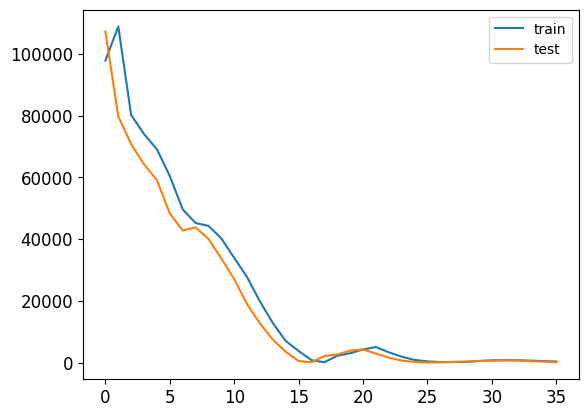

In [48]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train', 'test'], loc='upper right')


plt.show()

In [49]:


mean_squared_error(y_test, y_pred)**0.5


12.966021723979999

In [50]:
prior_days3 = np.array(
    [ 383.869995,386.25,388.859985,382.359985,383.709991,386.149994,383.809998,380.579987,371.540009 ]
)

# reshape into the three dimensions for input into model
prior_days3 = prior_days3.reshape(1, 9, 1) # 1 row, 59 time steps (features), and 1 output/prediction)

In [51]:
model.predict(prior_days3) # note the structure of the prediction

1/1 [==============================] - 0s 28ms/step


array([[374.10727]], dtype=float32)

In [52]:
tomorrows_temp = model.predict(prior_days3)[0][0] # we see the predicted temp is embedded inside two dimensions

1/1 [==============================] - 0s 26ms/step


In [53]:
print(f"Tomorrow's predicted stock close is {tomorrows_temp:.2f} ")

Tomorrow's predicted stock close is 374.11 


## Results

The LTSM performs very well with multiple layers, LSTM addresses this problem by introducing a memory cell that can store information over long periods of time and by using gates that control the flow of information through the network.
This is our second best model with 12.9 mean squared error & 10th day predicted closing price is 374.1

# GRU (with more layers)

In [54]:
model = keras.models.Sequential([
    keras.layers.GRU(64, activation='relu', return_sequences=True, input_shape=[n_steps, n_inputs]),
    keras.layers.GRU(64, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [55]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='RMSprop')

history = model.fit(X_train, y_train, epochs=50,validation_data=(X_test, y_test), 
    callbacks=[early_stop])

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 139840.6719 - val_loss: 129556.4453
Epoch 2/50
1/1 [==============================] - 0s 50ms/step - loss: 131120.7969 - val_loss: 123324.2109
Epoch 3/50
1/1 [==============================] - 0s 63ms/step - loss: 124855.6016 - val_loss: 114850.1641
Epoch 4/50
1/1 [==============================] - 0s 54ms/step - loss: 116311.8516 - val_loss: 107435.2578
Epoch 5/50
1/1 [==============================] - 0s 53ms/step - loss: 108784.5859 - val_loss: 102394.5234
Epoch 6/50
1/1 [==============================] - 0s 52ms/step - loss: 103795.2109 - val_loss: 98367.2734
Epoch 7/50
1/1 [==============================] - 0s 54ms/step - loss: 99734.3047 - val_loss: 94639.7500
Epoch 8/50
1/1 [==============================] - 0s 52ms/step - loss: 95977.3203 - val_loss: 91188.6328
Epoch 9/50
1/1 [==============================] - 0s 57ms/step - loss: 92479.0703 - val_loss: 88114.9609
Epoch 10/50
1/1 [=============================

### Predictions

In [56]:
#Predict:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 431ms/step


In [57]:
mean_squared_error(y_test, y_pred)**0.5

5.289214455847014

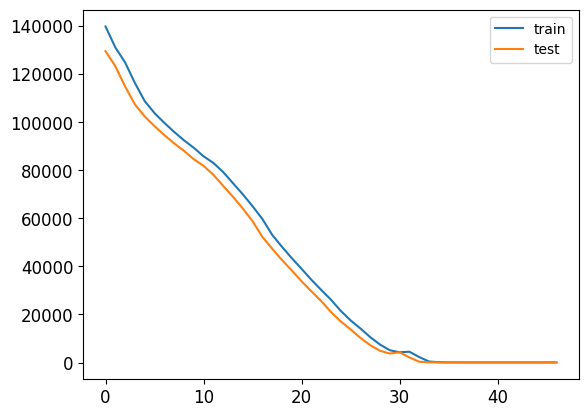

In [58]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train', 'test'], loc='upper right')


plt.show()

In [59]:
prior_days4 = np.array(
    [ 383.869995,386.25,388.859985,382.359985,383.709991,386.149994,383.809998,380.579987,371.540009 ]
)

# reshape into the three dimensions for input into model
prior_days4 = prior_days4.reshape(1, 9, 1) # 1 row, 59 time steps (features), and 1 output/prediction)

In [60]:
model.predict(prior_days4) # note the structure of the prediction

1/1 [==============================] - 0s 37ms/step


array([[378.2499]], dtype=float32)

In [61]:
tomorrows_temp = model.predict(prior_days4)[0][0] # we see the predicted temp is embedded inside two dimensions

1/1 [==============================] - 0s 42ms/step


In [62]:
print(f"Tomorrow's predicted stock close is {tomorrows_temp:.2f} ")

Tomorrow's predicted stock close is 378.25 


# Results
The GRU is the best performing model as per our data, we can observe that the mean squared error is the least at 5.2 and the 10th day closing stock price is 378.25

# Conv1D

### Last Layer: GRU (you can change it to SimpleRNN or LSTM as well)

In [63]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[n_steps, n_inputs]),
    keras.layers.GRU(64, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), 
    callbacks=[early_stop])

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 119438.1016 - val_loss: 113412.7188
Epoch 2/50
1/1 [==============================] - 0s 39ms/step - loss: 114833.7969 - val_loss: 109534.0938
Epoch 3/50
1/1 [==============================] - 0s 48ms/step - loss: 110927.8359 - val_loss: 106497.6484
Epoch 4/50
1/1 [==============================] - 0s 50ms/step - loss: 107747.8594 - val_loss: 102692.6875
Epoch 5/50
1/1 [==============================] - 0s 51ms/step - loss: 104004.3906 - val_loss: 99788.8359
Epoch 6/50
1/1 [==============================] - 0s 45ms/step - loss: 101288.2734 - val_loss: 99712.1562
Epoch 7/50
1/1 [==============================] - 0s 53ms/step - loss: 100414.8047 - val_loss: 95178.5000
Epoch 8/50
1/1 [==============================] - 0s 47ms/step - loss: 96495.5391 - val_loss: 92559.6250
Epoch 9/50
1/1 [==============================] - 0s 47ms/step - loss: 93781.4297 - val_loss: 90408.8984
Epoch 10/50
1/1 [=============================

### Predictions

In [65]:
#Predict:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 477ms/step


In [66]:
mean_squared_error(y_test, y_pred)**0.5

27.4027801094376

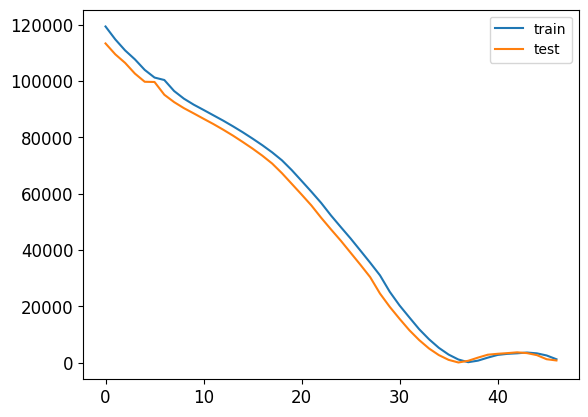

In [67]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train', 'test'], loc='upper right')


plt.show()

In [68]:
prior_days5 = np.array(
    [ 383.869995,386.25,388.859985,382.359985,383.709991,386.149994,383.809998,380.579987,371.540009 ]
)

# reshape into the three dimensions for input into model
prior_days5 = prior_days5.reshape(1, 9, 1) # 1 row, 59 time steps (features), and 1 output/prediction)

In [69]:
model.predict(prior_days5) # note the structure of the prediction

1/1 [==============================] - 0s 34ms/step


array([[407.59747]], dtype=float32)

In [70]:
tomorrows_temp = model.predict(prior_days5)[0][0] # we see the predicted temp is embedded inside two dimensions

1/1 [==============================] - 0s 32ms/step


In [71]:
print(f"Tomorrow's predicted stock close is {tomorrows_temp:.2f} ")

Tomorrow's predicted stock close is 407.60 


## Results
the 10th day predicted stock price is 407.6, we can see that the plotted data is on par with our actual & predicted values but this is not as good as GRU model

# Discussion & Conclusion

GRU is a simplified version of LSTM that also uses gates to control the flow of information but has fewer parameters than LSTM. GRU is faster to train and requires less memory than LSTM but may not perform as well on more complex problems.
GRU has given us the least mean squared error and we had predicted the closing price of 10th day based on few 9 days data we gathered.
This method follows a different approach compared to our previous method where we had standardized the values and splitted the data based on chronological order.
The first method was train sequentially on each 9 days split to predict the 10th day, though the second model has also trained on previous 9 days and predicted the 10th day as target column, howoever when testing this we had given a array of input data ourselves and it had predicted the 10th day based on past 9 days. 